In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Overview

- robotics can essentially be broken down into a three step cycle
    - the first step is to sense or perceive the world
    - the second step is to decide what to do based on that perception
    - the third step is to perform an action to carry out that decision
    
- computer vision is a major part of the perception step in that cycle
- computer vision is the art and science of perceiving and understanding the world around you through images

- Radar and Lidar see the world in 3D, which can be a big advantage for knowing where you are relative to your environment
- a camera sees in 2D, but at much higher spatial resolution than Radar and Lidar such that it's actually possible to infer depth information from camera images
- the big difference, however, comes down to cost, where cameras are significantly cheaper

- ultimate goal in this first section is to measure some of the quantities that need to be known in order to control the car
- for example, to steer a car, you'll need to measure how much your lane is curving
- to do that, you need to map out the lens in your camera images, after transforming them to a different perspective
    - one way, you're looking down on the road from above
- in order to get this perspective transformation right, you first have to correct for the effect of image distortion

- cameras don't create perfect images
- some of the objects in the images, especially ones near the edges, can get stretched or skewed in various ways and you need to correct for that

# Distortion Correction

- when we talk about image distortion, we're talking about what happens when a camera looks at 3D objects in the real world and transforms them into a 2D image
    - this transformation isn't perfect

<img src="resources/camera_distortion.png" style="width: 70%;"/>

- for example, here's an image of a road and some images taken through different camera lenses that are slightly distorted
- in these distorted images, you can see that the edges of the lanes are bent and sort of rounded or stretched outward and distortion is actually changing what the shape and size of these objects appears to be
- this is a problem, because we're trying to accurately place the self-driving car in this world
- eventually, we'll want to look at the curve of a lane and steer the correct direction
    - but if the lane is distorted, we'll get the wrong measurement for curvature in the first place and our steering angle will be wrong
    - so, the first step in analyzing camera images is to undo this distortion so that we can get correct and useful information out of them

# Pinhole Camera Model

<img src="resources/pinholecameramodel_thehumaneye.png" style="width: 70%;"/>

- here's a simple model of a camera called the *pinhole camera model*
- when the camera forms an image, it's looking at the world similar to how our eyes do; by focusing the light that's reflected off of objects in the world

<img src="resources/cameramatrix_3d2d.png" style="width: 70%;"/>

- in this case through a small pinhole, the camera focuses the light that's reflected off of a 3D traffic sign, and forms a 2D image at the back of the camera or a sensor or some film would be placed
    - in fact the image it forms here will be upside down, and reversed because rays of light that enter from the top of an object will continue on that angled path through the pinhole and end up at the bottom of the formed image
    - similarly, light that reflects off the right side of an object will travel to the left of the formed image
    - in math this transformation from 3D object points, *P(X,Y,Z)* to 2D image points, *P(X,Y)* is done by a transformative matrix called *the camera matrix*

<img src="resources/pinholecamera_convexlens.png" style="width: 70%;"/>

- real cameras don't use tiny pinholes like described above
- they use lenses to focus multiple light rays at a time which allows them to quickly form images
- but lenses can introduce distortion too
- light rays often bend a little too much or too little at the edges of a curved lens of a camera
    - this creates the effect we looked at earlier that distorts the edges of images

- ***radial distortion*** - edges of images are distorted so lines or objects appear more or less curved than they actually are
    - caused because real cameras use curved lenses to form an image, and light rays often bend a little too much or too little at the edges of these lenses
    - it's the most common type of distortion
- ***tangential distortion*** - if the camera's lens is not aligned perfectly parallel to the imaging plane where the camera film or sensor is, this makes an image look tilted
    - so that some objects appear further away or closer than they actually are

## Distortion Coefficients and Correction

- for our purposes we are using images to position our self driving car and eventually steer it the right direction
- we need undistorted images that accurately reflect our real world surroundings
- this distortion can generally be captured by five numbers called *distortion coefficients*, whose values reflect the amount of radial and tangential distortion in an image
    - $Distortion_{coeficients}=(k_1\ k_2\ p_1\ p_2\ k_3)$
- in severely distorted cases, sometimes even more than five coefficients are required to capture the amount of distortion
- if we know these coefficients, we can use them to calibrate our camera and undistort our images

- there are three coefficients needed to correct for radial distortion: `k1, k2, and k3`
- to correct the appearance of radially distorted points in an image, one can use a correction formula
- in the following equations, *(x,y)* is a point in a distorted image
- $(x_{corrected}, y_{corrected})$ is where that point will appear in the undistorted (corrected) image
- to undistort these points, OpenCV calculates *r*, which is the known distance between a point in an undistorted (corrected) image $(x_{corrected}, y_{corrected})$ and the center of the image distortion, which is often the center of that image $(x_c, y_c)$
- this center point $(x_c, y_c)$ is sometimes referred to as the distortion center
- these points are pictured below

<img src="resources/distorted_coefitients.png" style="width: 70%;"/>

**Note:** 
- the distortion coefficient *k3* is required to accurately reflect major radial distortion (like in wide angle lenses)
- however, for minor radial distortion, which most regular camera lenses have, *k3* has a value close to or equal to zero and is negligible
- so, in OpenCV, you can choose to ignore this coefficient; this is why it appears at the end of the distortion values array: $[k1, k2, p1, p2, k3]$
- in this course, we will use it in all calibration calculations so that our calculations apply to a wider variety of lenses (wider, like wide angle) and can correct for both minor and major radial distortion

- **radial distortion correction equations**
<br/>
$x_{distorted}=x_{ideal}(1+k_1r^2+k_2r^4+k_3r^6)$
<br/>
$y_{distorted}=y_{ideal}(1+k_1r^2+k_2r^4+k_3r^6)$

- **tangential distortion correction equations**
- there are two more coefficients that account for tangential distortion: *p1* and *p2*, and this distortion can be corrected using a different correction formula
<br/>
$x_{corrected}=x+[2p_1xy+p_2(r^2+2x^2)]$
<br/>
$y_{corrected}=y+[p_1(r^2+2y^2)+2p_2xy]$

# Measuring Distortion

- we know that distortion changes the size and shapes of objects in an image, but how do we calibrate for that?
- well, we can take pictures of known shapes, then we'll be able to detect and correct any distortion errors
- we could choose any shapes to calibrate our camera, and we'll use a chessboard
    - a chessboard is great for calibration because its regular high contrast pattern makes it easy to detect automatically
    - and we know what an undistorted flat chessboard looks like
    - so, if we use our camera to take multiple pictures of a chessboard against a flat surface, then we'll be able to detect any distortion by looking at the difference between the apparent size and the shape of the squares in these images, and the size and shape that they actually are
    - then we'll use that information to calibrate our camera
        - create a transform that maps these distorted points to undistorted points
        - and finally, undistort any images

# Finding Corners

- `cv2.findChessboardCorners()`
    - http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners
- `cv2.drawChessboardCorners()`
    - http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.drawChessboardCorners

- count the number of corners in any given row and enter that value in `nx`
- similarly, count the number of corners in a given column and store that in `ny`
- keep in mind that "corners" are only points where two black and two white squares intersect, in other words, only count inside corners, not outside corners

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<IPython.core.display.Javascript object>

In [3]:
# Prepare object points
nx = 8  # the number of inside corners in x
ny = 6  # the number of inside corners in y

<IPython.core.display.Javascript object>

In [4]:
# Make a list of calibration images
fname = "resources/calibration_test.png"
img = cv2.imread(fname)

<IPython.core.display.Javascript object>

In [5]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

<IPython.core.display.Javascript object>

In [6]:
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

<IPython.core.display.Javascript object>

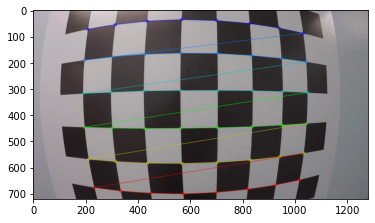

<IPython.core.display.Javascript object>

In [7]:
# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

# Calibrating Your Camera and Correcting for Distortion

In [8]:
import glob

<IPython.core.display.Javascript object>

In [9]:
# Read in a calibration images
images = glob.glob("resources/calibration_wide/GOPR00*.jpg")

<IPython.core.display.Javascript object>

- map the coordinates of the corners in this 2D image (image points) to the 3D coordinates of the real undistorted chessboard corners (object points)
- the object points will all be the same; just the known object coordinates of the chessboard corners for an eight by six board
    - these points will be 3D coordinates, *x*, *y* and *z* from the top left corner, *0, 0, 0*, to the bottom right, *6, 4, 0* (relative to the origin corner - *0, 0, 0*)
    - the *z* coordinate will be zero for every point, since the board is on a flat image plane

In [10]:
# Arrays to store object points and image points from all the images
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

<IPython.core.display.Javascript object>

In [11]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ... (6, 4, 0)
# by creating six by eight points in an array
# each with three columns for the x, y, and z coordinates of each corner
# initialize these all as zeros using Numpy's zero function
objp = np.zeros((6 * 8, 3), np.float32)

# z coordinate will stay zero but for first two columns, x and y
# use numpy's mgrid function to generate the coordinates that we want
# mgrid returns the coordinate values for a given grid size
# shape those coordinates back into two columns, one for x and one for y
objp[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)  # x, y coordinates

<IPython.core.display.Javascript object>

- `numpy.mgrid()` https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html

In [12]:
for fname in images:
    # Read in each image
    img = mpimg.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(
            objp
        )  # these object points will be the same for all of the calibration images, since they represent a real chessboard

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (8, 6), corners, ret)
#         plt.figure()
#         plt.imshow(img)

<IPython.core.display.Javascript object>

**Note:**
- if you are reading in an image using `mpimg.imread()` this will read in an RGB image and you should convert to grayscale using `cv2.COLOR_RGB2GRAY`
- if you are using `cv2.imread()` or the glob API, as happens in this video example, this will read in a BGR image and you should convert to grayscale using `cv2.COLOR_BGR2GRAY`

- to calibrate a camera, OpenCV gives us the `calibrateCamera()` function
    - https://docs.opencv.org/master/d9/d0c/group__calib3d.html
    - this takes in our object points, our image points, and the shape of the image
    - using these inputs, it calculates and returns the distortion coefficients and the camera matrix that we need to transform 3D object points to 2D image points
    - it also returns the position of the camera in the world, with values for rotation and translation vectors
    - `ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)`

- next function you'll need is `undistort()`
    - this takes in a distorted image, our camera matrix, and distortion coefficients
    - it returns an undistorted, often called destination image
    - `dst = cv2.undistort(img, mtx, dist, None, mtx)`

**A note on image shape**
- the shape of the image, which is passed into the `calibrateCamera` function, is just the height and width of the image
- one way to retrieve these values is by retrieving them from the grayscale image shape array `gray.shape[::-1]`
- this returns the image width and height in pixel values like (1280, 960)


- another way to retrieve the image shape, is to get them directly from the color image by retrieving the first two values in the color image shape array using `img.shape[1::-1]`
- this code snippet asks for just the first two values in the shape array, and reverses them
- note that in our case we are working with a greyscale image, so we only have 2 dimensions (color images have three, height, width, and depth), so this is not necessary


- it's important to use an entire grayscale image shape or the first two values of a color image shape
- this is because the entire shape of a color image will include a third value -- the number of color channels -- in addition to the height and width of the image
- for example the shape array of a color image might be (960, 1280, 3), which are the pixel height and width of an image (960, 1280) and a third value (3) that represents the three color channels in the color image, and if you try to pass these three values into the `calibrateCamera` function, you'll get an error

In [13]:
# Test undistortion on an image
img = cv2.imread("resources/calibration_wide/test_image.jpg")
img_size = (img.shape[1], img.shape[0])

<IPython.core.display.Javascript object>

In [14]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, img_size, None, None
)

<IPython.core.display.Javascript object>

In [15]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite("resources/calibration_wide/test_undist.jpg", undist)

True

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Undistorted Image')

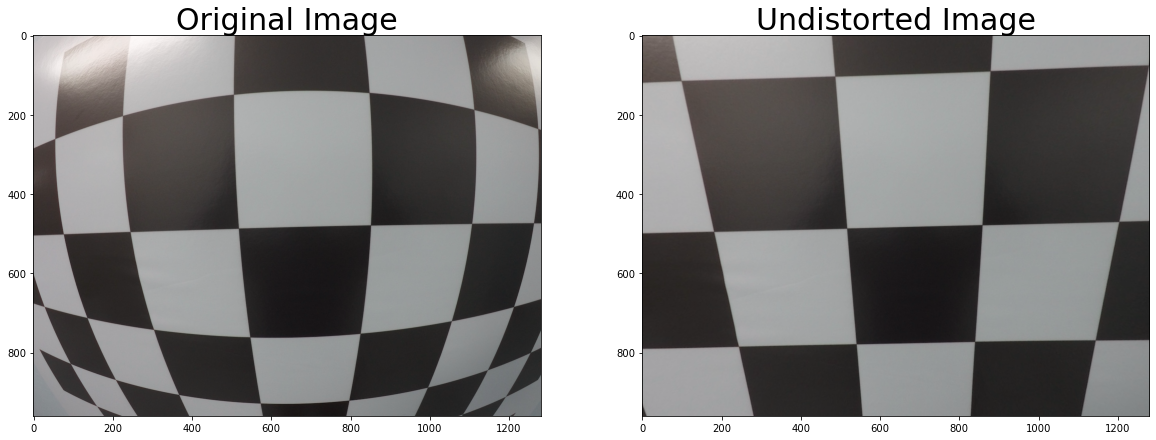

<IPython.core.display.Javascript object>

In [16]:
# dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title("Original Image", fontsize=30)
ax2.imshow(undist)
ax2.set_title("Undistorted Image", fontsize=30)

# Lane Curvature

- one really important piece of information from images of the road is lane curvature
- self-driving cars need to be told the correct steering angle to turn left or right
    - we can calculate this angle if we know a few things about the speed and dynamics of the car and how much the lane is curving

- to determine the curvature, we'll go through the following steps
    - detect the lane lines using some masking and thresholding techniques
    - perform a perspective transform to get a birds eye view of the lane
        - this let's us fit a polynomial to the lane lines (which we couldn't do very easily before)
    - then, we can extract the curvature the lines from this polynomial with just a little math

- one way to calculate the curvature of a lane line, is to fit a 2nd degree polynomial to that line, and from this you can easily extract useful information
- for a lane line that is close to vertical, you can fit a line using this formula: $f(y) = Ay^2 + By + C$, where *A*, *B*, and *C* are coefficients
- *A* gives you the curvature of the lane line
- *B* gives you the heading or direction that the line is pointing
- *C* gives you the position of the line based on how far away it is from the very left of an image (*y = 0*)

# Perspective Transform

- in an image, perspective is the phenomenon where an object appears smaller the farther away it is from a viewpoint like a camera, and parallel lines appear to converge to a point
- mathematically, we can characterize perspective by saying that in real world coordinates *x*, *y*, and *z*, the greater the magnitude of an objects *z* coordinate, or distance from the camera, the smaller it will appear in a 2D image
    - a perspective transform uses this information to transform an image
    - it essentially transforms the apparent *z* coordinate of the object points, which in turn changes that object's 2D image representation

- a perspective transform warps the image and effectively drags points towards or pushes them away from the camera to change the apparent perspective
- a perspective transform let's us change our perspective to view the same scene from different viewpoints and angles
    - this could be viewing a scene from the side of a camera, from below the camera, or looking down on the road from above

- some tasks, like finding the curvature of a lane, are easier to perform on a bird's eye view of an image
- doing a bird's-eye view transform is especially helpful for road images because it will also allow us to match a car's location directly with a map, since map's display roads and scenery from a top down view

- the process of applying a perspective transform will be kind of similar to how we applied undistortion
- but this time, instead of mapping object points to image points, we want to map the points in a given image to different desired image points with a new perspective

<img src="resources/map_points_perspective.png" style="width: 80%;"/>

- and again, this perspective can be done for all kinds of different viewpoints, whether that's from above like with a map or from different camera angles

# Transform a Stop Sign

- we care about the perspective transform because the software we've written will eventually do this to images of a road, so that you can find the lane curvature
- we're using a traffic sign as an example here mainly because it's easiest to see that you've performed a perspective transform correctly on images with text or other distinct reference points

- to create a perspective transform, we'll first select four points that define a rectangle on a plane in this image
- four points are enough to define a linear transformation from one perspective to another
- in this case, we're selecting point that define a plane on the surface of the STOP sign
- we'll also select where we want those same four points to appear and are transformed, often called warped image
- then, we can use OpenCV functions to calculate the transform that maps the points in the original image to the warped image with the different perspective

In [17]:
%matplotlib qt

# Read and display the original image
img = mpimg.imread("resources/stop_sign.png")
plt.imshow(img)

<IPython.core.display.Javascript object>

- first, manually create four points on this original source image

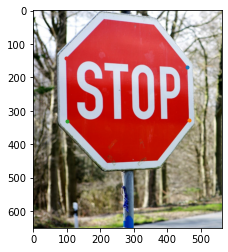

<IPython.core.display.Javascript object>

In [18]:
%matplotlib inline

# source image points
plt.imshow(img)
plt.plot(459, 168, ".")  # top right
plt.plot(464, 328, ".")  # bottom right
plt.plot(101, 329, ".")  # bottom left
plt.plot(98, 143, ".")  # top left


In [19]:
# Define perspective transform function
def warp(img):

    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])

    # Four source coordinates
    src = np.float32([[459, 168], [464, 328], [101, 329], [98, 143]])

    # Four desired coordinates
    # choose points by just eyeballing a rectangle in that same image
    # from the top-right corner, around to the top left
    dst = np.float32([[443, 155], [443, 330], [115, 330], [115, 155]])

    # Compute the perspective transform, M (matrix)
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create warped image using the perspective transform, M - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

<IPython.core.display.Javascript object>

**Note:** When you apply a perspective transform, choosing four source points manually, as we did in this video, is often not the best option. There are many other ways to select source points. For example, many perspective transform algorithms will programmatically detect four source points in an image based on edge or corner detection and analyzing attributes like color and surrounding pixels.

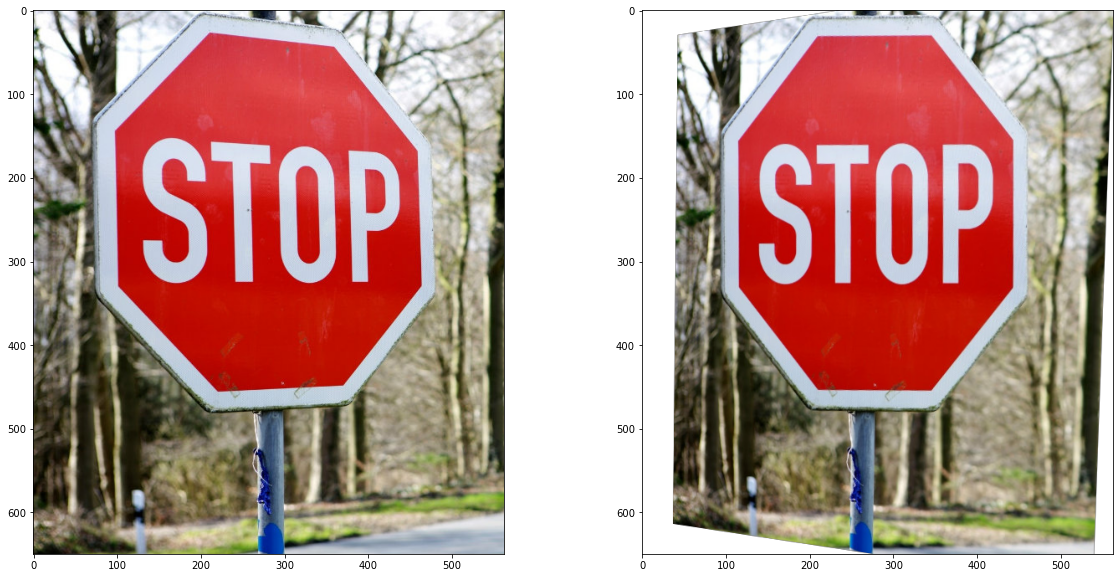

<IPython.core.display.Javascript object>

In [20]:
# Get perspective transform
warped_im = warp(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax2.imshow(warped_im)

# Undistort and Transform

In [21]:
# Read in an image
img = cv2.imread("resources/undistort_chessboard.png")
nx = 8  # the number of inside corners in x
ny = 6  # the number of inside corners in y

<IPython.core.display.Javascript object>

In [22]:
# MODIFY THIS FUNCTION TO GENERATE OUTPUT
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found:
    # a) draw corners
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    # Note: you could pick any four of the detected corners
    # as long as those four corners define a rectangle
    # One especially smart way to do this would be to use four well-chosen
    # corners that were automatically detected during the undistortion steps
    # We recommend using the automatic detection of corners in your code
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    # e) use cv2.warpPerspective() to warp your image to a top-down view

    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100  # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx - 1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result
        # again, not exact, but close enough for our purposes
        dst = np.float32(
            [
                [offset, offset],
                [img_size[0] - offset, offset],
                [img_size[0] - offset, img_size[1] - offset],
                [offset, img_size[1] - offset],
            ]
        )
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

<IPython.core.display.Javascript object>

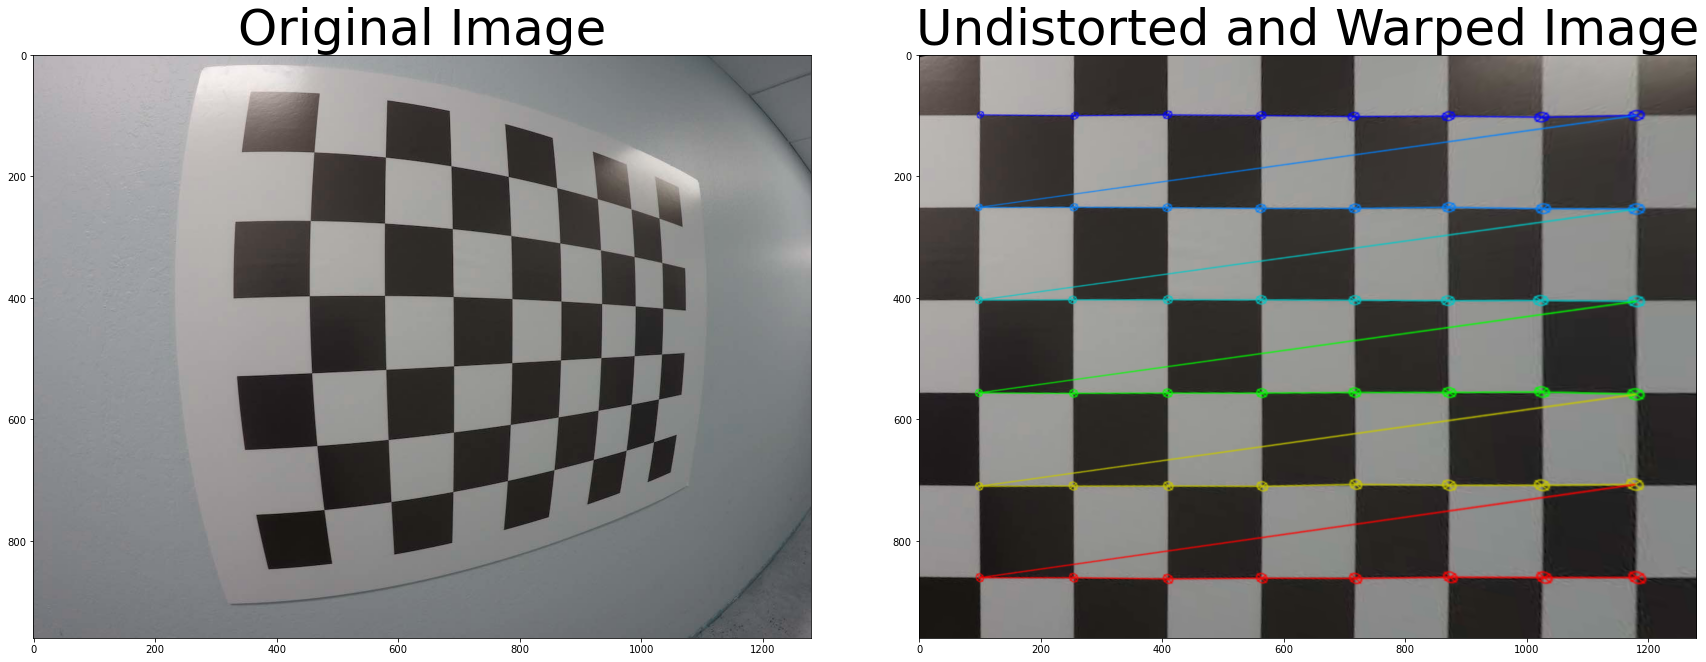

<IPython.core.display.Javascript object>

In [23]:
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title("Original Image", fontsize=50)
ax2.imshow(top_down)
ax2.set_title("Undistorted and Warped Image", fontsize=50)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)